In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import networkx as nx
from community import community_louvain

import pycountry
import seaborn as sns

import collections
import jellyfish

import bs4 as bs  
import urllib.request  
import re  
import nltk

#from py_translator import Translator
from googletrans import Translator
from gensim.models import Word2Vec

# Importing the notebook with all the methods definition
import importlib
import GKG

import copy
import simplejson as json

In [2]:
uk_actor = pd.read_csv('../CSV Files/uk_actors.csv', sep='\t', delimiter='\t', decimal = '.', error_bad_lines=False, 
                                  engine='c', encoding='latin-1')

In [3]:
dates = list(uk_actor['V2.1DATE'])
np.min(dates), np.max(dates)

(20190329000000.0, 20190418234500.0)

In [42]:
importlib.reload(GKG)

<module 'GKG' from '/Users/aminmekacher/Documents/EPFL Master/MA2/GDELT Project/GDELT-Project/Notebooks/GKG.py'>

In [3]:
# Extraction of the themes mentioned in the Tunisia Actor dataframe
theme_list = GKG.theme_list_extraction(uk_actor)

In [4]:
tf_total, idf_total, tf_idf_total = GKG.tf_idf_computation(dataframe=uk_actor, themes_of_interest=theme_list)

Num:  68379


In [43]:
tf_total2, idf_total2, tf_idf_total2 = GKG.tf_idf_computation(dataframe=uk_actor, themes_of_interest=theme_list)

KeyboardInterrupt: 

Goal: create a graph with each mentioned actor connected between each other if they are named in the same articles

In [5]:
# Actor network creation
G_actor = nx.Graph()
GKG.social_graph_creation(G_actor, uk_actor)

list_actor = list(G_actor.nodes)
nodes_actor = len(list(G_actor.nodes))
edges_actor = len(list(G_actor.edges))
print("--- UK Actor ---")
print("A total of %d actors have been detected" % nodes_actor)
print("A total of %d edges have been drawn" % edges_actor)

--- UK Actor ---
A total of 9482 actors have been detected
A total of 493967 edges have been drawn


/Users/aminmekacher/miniconda3/envs/gdelt_project/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Distribution of the edge weight for the UK actor network')

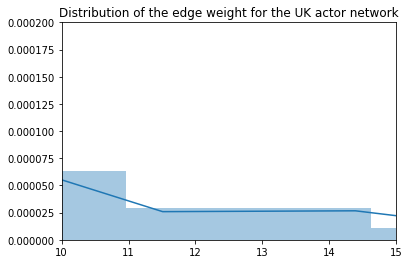

In [6]:
# Display of a histogram showing the distribution of the edge weight in the actor graph

edges_weight = nx.get_edge_attributes(G_actor, 'weight')
weight_list = []

for actor_edge in G_actor.edges:
    weight_list.append(edges_weight[actor_edge])

sns.distplot(weight_list, bins=100)
plt.ylim(0, 0.0002)
plt.xlim(10, 15)
plt.title("Distribution of the edge weight for the UK actor network")

In [7]:
# Definition of an actor network with weak edges (weight < 0.72) removed

threshold_high = 11
G_actor_threshold_high = copy.deepcopy(G_actor)
G_actor_threshold_high = GKG.network_edge_filtering(graph=G_actor_threshold_high, threshold=threshold_high)

threshold_low = 3.8
G_actor_threshold_low = copy.deepcopy(G_actor)
G_actor_threshold_low = GKG.network_edge_filtering(graph=G_actor_threshold_low, threshold=threshold_low)

Removed edge:  493826
Removed nodes:  9405
Removed edge:  493297
Removed nodes:  9184


In [8]:
# Computation of the page rank for each actor. This value is then assigned as an attribute

pagerank_actor = nx.algorithms.link_analysis.pagerank_alg.pagerank(G_actor)
pagerank_high = nx.algorithms.link_analysis.pagerank_alg.pagerank(G_actor_threshold_high)
pagerank_low = nx.algorithms.link_analysis.pagerank_alg.pagerank(G_actor_threshold_low)
        
for actor in list(G_actor.nodes):
    G_actor.node[actor]['pageRank'] = float(pagerank_actor[actor])
    
for actor in list(G_actor_threshold_high.nodes):
    G_actor_threshold_high.node[actor]['pageRank'] = float(pagerank_high[actor])
    
for actor in list(G_actor_threshold_low.nodes):
    G_actor_threshold_low.node[actor]['pageRank'] = float(pagerank_low[actor])

In [10]:
# By using the PageRank attribute, we can extract the 10 most influential actors in the network

# High Threshold

actor_dict_high = dict(G_actor_threshold_high.nodes)
sorted_actor_dict_high = dict(sorted(actor_dict_high.items(), key = lambda x: x[1]['pageRank'], reverse=True))

topk_actor_high = GKG.topk_actor_extraction(sorted_actor_dict_high, k=10)

# Low Threshold

actor_dict_low = dict(G_actor_threshold_low.nodes)
sorted_actor_dict_low = dict(sorted(actor_dict_low.items(), key = lambda x: x[1]['pageRank'], reverse=True))

topk_actor_low = GKG.topk_actor_extraction(sorted_actor_dict_low, k=10)

In [11]:
# Study of the cliques in the actor social network

partition = community_louvain.best_partition(G_actor)
for node_actor in list(G_actor.nodes):
    G_actor.node[node_actor]['community'] = partition[node_actor]
    
partition_high = community_louvain.best_partition(G_actor_threshold_high)
for node_actor in list(G_actor_threshold_high.nodes):
    G_actor_threshold_high.node[node_actor]['community'] = partition_high[node_actor]
    
partition_low = community_louvain.best_partition(G_actor_threshold_low)
for node_actor in list(G_actor_threshold_low.nodes):
    G_actor_threshold_low.node[node_actor]['community'] = partition_low[node_actor]

filepath_actor = '../Gephi Files/uk_actor.gexf'
nx.write_gexf(G_actor, filepath_actor, version="1.2draft")

filepath_threshold_low = '../Gephi Files/uk_threshold_low.gexf'
nx.write_gexf(G_actor_threshold_low, filepath_threshold_low, version='1.2draft')

filepath_threshold_high = '../Gephi Files/uk_threshold_high.gexf'
nx.write_gexf(G_actor_threshold_high, filepath_threshold_high, version='1.2draft')

In [6]:
# Save the tfidf dictionary in an external file

import simplejson as json

json_tfidf = json.dumps(tf_idf_total)
f = open("../JSON_files/uk_tfidf.json","w")
f.write(json_tfidf)
f.close()

In [7]:
with open('../JSON_files/switzerland_tfidf.json', 'r') as f:
    distros_dict = json.load(f)

In [9]:
G_actor = GKG.load_json(fname='../JSON_files/uk_actor_threshold_high')
list_actor = list(G_actor.nodes)
tf_idf_total = distros_dict

In [28]:
len(list(tf_idf_total.keys()))

62677

In [19]:
importlib.reload(GKG)

<module 'GKG' from '/Users/aminmekacher/Documents/EPFL Master/MA2/GDELT Project/GDELT-Project/Notebooks/GKG.py'>

In [20]:
# Theme network generation

# High Threshold

G_themes_high = nx.Graph()
G_themes_high = nx.create_empty_copy(G_actor)
list_actor_high = list(G_themes_high.nodes)
GKG.theme_network_creation(G_themes_high, list_actor, uk_actor, theme_list, tf_idf_total)

nodes_themes = len(list(G_themes_high.nodes))
edges_themes = len(list(G_themes_high.edges))
print("--- UK Themes High---")
print("A total of %d themes have been detected" % nodes_themes)
print("A total of %d edges have been drawn" % edges_themes)

for theme in theme_list:
    if G_themes_high.has_node(theme):
        G_themes_high.node[theme]['nodeType'] = 'Theme'
    
for node in list(G_themes_high.nodes):
    if node not in theme_list:
        G_themes_high.node[node]['nodeType'] = 'Actor'
        
filepath_theme_high = '../Gephi Files/uk_themes_high.gexf'
nx.write_gexf(G_themes_high, filepath_theme_high, version='1.2draft')

begin:  Jeremy Corbyn,390 GENERAL_GOVERNMENT,264;GENERAL_GOVERNMENT,548;GENERAL_GOVERNMENT,602;EPU_POLICY_GOVERNMENT,264;EPU_POLICY_GOVERNMENT,548;EPU_POLICY_GOVERNMENT,602;USPEC_UNCERTAINTY1,575;TERROR,652;REBELS,652;WB_2433_CONFLICT_AND_VIOLENCE,652;WB_2451_REBELS_GUERRILLAS_AND_INSURGENTS,652;WB_2432_FRAGILITY_CONFLICT_AND_VIOLENCE,652;WB_2445_NON_STATE_SECURITY_ACTORS,652;CRISISLEX_C07_SAFETY,652;RESIGNATION,440;TAX_FNCACT_LEADER,376; 20190330063000-6
Here:  20190330063000-6
Theme:  20190330063000-6 GENERAL_GOVERNMENT


KeyError: '20190330063000-6'

In [ ]:
# Definition of a new graph, with only the most influential actors kept

# High Threshold

G_influence_high = G_themes_high.copy()
nodes_to_remove = []

for node in G_influence_high.nodes:
    remove_node = node not in theme_list and node not in topk_actor_high
    #print("node: ", node, remove_node)
    
    if remove_node:
        nodes_to_remove.append(node)

G_influence_high.remove_nodes_from(nodes_to_remove)
G_influence_high.nodes

filepath_influence_high = '../Gephi Files/uk_influence_high.gexf'
nx.write_gexf(G_influence_high, filepath_influence_high, version='1.2draft')

# Low Threshold

G_influence_low = G_themes_low.copy()
nodes_to_remove = []

for node in G_influence_low.nodes:
    remove_node = node not in theme_list and node not in topk_actor_low
    #print("node: ", node, remove_node)
    
    if remove_node:
        nodes_to_remove.append(node)

G_influence_low.remove_nodes_from(nodes_to_remove)
G_influence_low.nodes

filepath_influence_low = '../Gephi Files/uk_influence_low.gexf'
nx.write_gexf(G_influence_low, filepath_influence_low, version='1.2draft')

In [ ]:
# High Threshold

strongest_themes = {}

print("--- High Threshold UK ---")
for node in G_influence_high.nodes:
    if G_influence_high.node[node]['nodeType'] == 'Actor':
    
        theme_list = []
        weight_list = []

        strongest_themes[node] = {}
        edges = list(G_influence_high.edges(node, data=True))

        for edge in edges:
            theme_edge = edge[1]
            weight_edge = edge[2]['weight']

            theme_list.append(theme_edge)
            weight_list.append(weight_edge)
    
        index_themes = np.flip(np.argsort(weight_list))[0:5]
        
        print("--- ", node, " ---")
            
        print([theme_list[index] for index in index_themes])
       

# Low Threshold

strongest_themes = {}

for node in G_influence_low.nodes:
    if G_influence_low.node[node]['nodeType'] == 'Actor':
    
        theme_list = []
        weight_list = []

        strongest_themes[node] = {}
        edges = list(G_influencelow.edges(node, data=True))

        for edge in edges:
            theme_edge = edge[1]
            weight_edge = edge[2]['weight']

            theme_list.append(theme_edge)
            weight_list.append(weight_edge)
    
        index_themes = np.flip(np.argsort(weight_list))[0:5]
        
        print("--- ", node, " ---")
            
        print([theme_list[index] for index in index_themes])